In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import seaflowpy as sfp
import mpld3 
import sys

import glob
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})



/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def get_filter_line(inst, regime_in, regime_out, bead_coords, calib):
    slopes = pd.DataFrame()
    intercept = pd.DataFrame()
    bead_coord = pd.DataFrame()
    
       
    bead_coord['fsc_small'] = bead_coords.fsc_small[(bead_coords['inst']==inst) & (bead_coords['regime']==regime_out)]
    #bead_coord['D2'] = bead_coords.D2[(bead_coords['inst']==inst) & (bead_coords['regime']==regime_out)]
    bead_coord['D1'] = bead_coords.D1[(bead_coords['inst']==inst) & (bead_coords['regime']==regime)]
    
    slopes['slope_S'] = calib.slope_S[(calib['inst']==inst) & (calib['regime']==regime_in)]
    slopes['slope_B'] = calib.slope_B[(calib['inst']==inst) & (calib['regime']==regime_in)]
    
    
    # function to find the intercept given the coordinates of the 1um beads
    intercept['S'] = bead_coord['D1'].values - slopes['slope_S'].values*bead_coord['fsc_small']
    intercept['B'] = bead_coord['D1'].values - slopes['slope_B'].values*bead_coord['fsc_small']

    return intercept, slopes

def align_evt(data, width, origin):
    # Filter aligned particles (D1 = D2), with correction for D1 D2
    # sensitivity difference
    alignedD1 = (data.df["D1"] + origin) < (data.df["D2"] + (width * 10**4))
    alignedD2 = data.df["D2"] < (data.df["D1"] + origin + (width * 10**4))
    aligned = data.df[alignedD1 & alignedD2]
    
    return aligned


In [3]:
# set the wdirectory where the data is stored

datadir = "/Volumes/ceg/Sophie/bead_calibration/"

# select instrument
inst = 751
instdir = "%3d_caldata" % inst

indir = "%s%s" % (datadir, instdir)
regime = 'oligo'

files = glob.glob('%s/*%s*.evt' % (indir, regime))

In [4]:
# best guess of the points needed for the filter function
# this is for the 751 oligo test
guess = pd.DataFrame()
guess['fsc_small'] = [62500, 57300, 57600, 53500, 48400, 38900, 19700]
guess['D1'] = [45500, 38400, 37400, 29400, 26800, 15900, 4700]
guess['bead'] = [5.7,3.1, 1.83, 1.0, 0.75, 0.5, 0.3]

# try to fit a polynomial to bead data
z = np.polyfit(guess['fsc_small'], guess['D1'], 2)
p = np.poly1d(z)
xp = np.linspace(0, 7e04, 100)

guess = guess.sort(['bead'], ascending = 1)

small = guess[guess['bead']<=1].reset_index(drop = True)
small = small.append(small.ix[len(small)-1,:], ignore_index=True)
print len(small)

big = guess[guess['bead']>=1]
big = big.append(big.ix[len(big)-1,:], ignore_index=True)
print len(big)
                 
weights = [1.0, 1.0, 1.0, 1.0, sys.float_info.epsilon]

# try to fit a polynomial to bead data
zs, vs = np.polyfit(small['fsc_small'], small['D1'], 1, w=weights, cov=True)
ps = np.poly1d(zs)

zb, vb = np.polyfit(big['fsc_small'], big['D1'], 1, w=weights, cov=True)
pb = np.poly1d(zb)

print "small slope: {} +/- {}".format(zs[0], np.sqrt(vs[0][0]))
print "small intercept: {} +/- {}".format(zs[1], np.sqrt(vs[1][1]))
print ' '
print "big slope: {} +/- {}".format(zb[0], np.sqrt(vb[0][0]))
print "big intercept: {} +/- {}".format(zb[1], np.sqrt(vb[1][1]))

5
5
small slope: 0.749976540712 +/- 0.11171019471
small intercept: -10892.8086961 +/- 4708.45881603
 
big slope: 1.76393904156 +/- 0.280386110298
big intercept: -64148.3811739 +/- 16210.0701793


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.75um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_5.7um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_1.83um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.3um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_noise.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_3.1um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.5um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_1um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_oligo_0.18um.evt


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


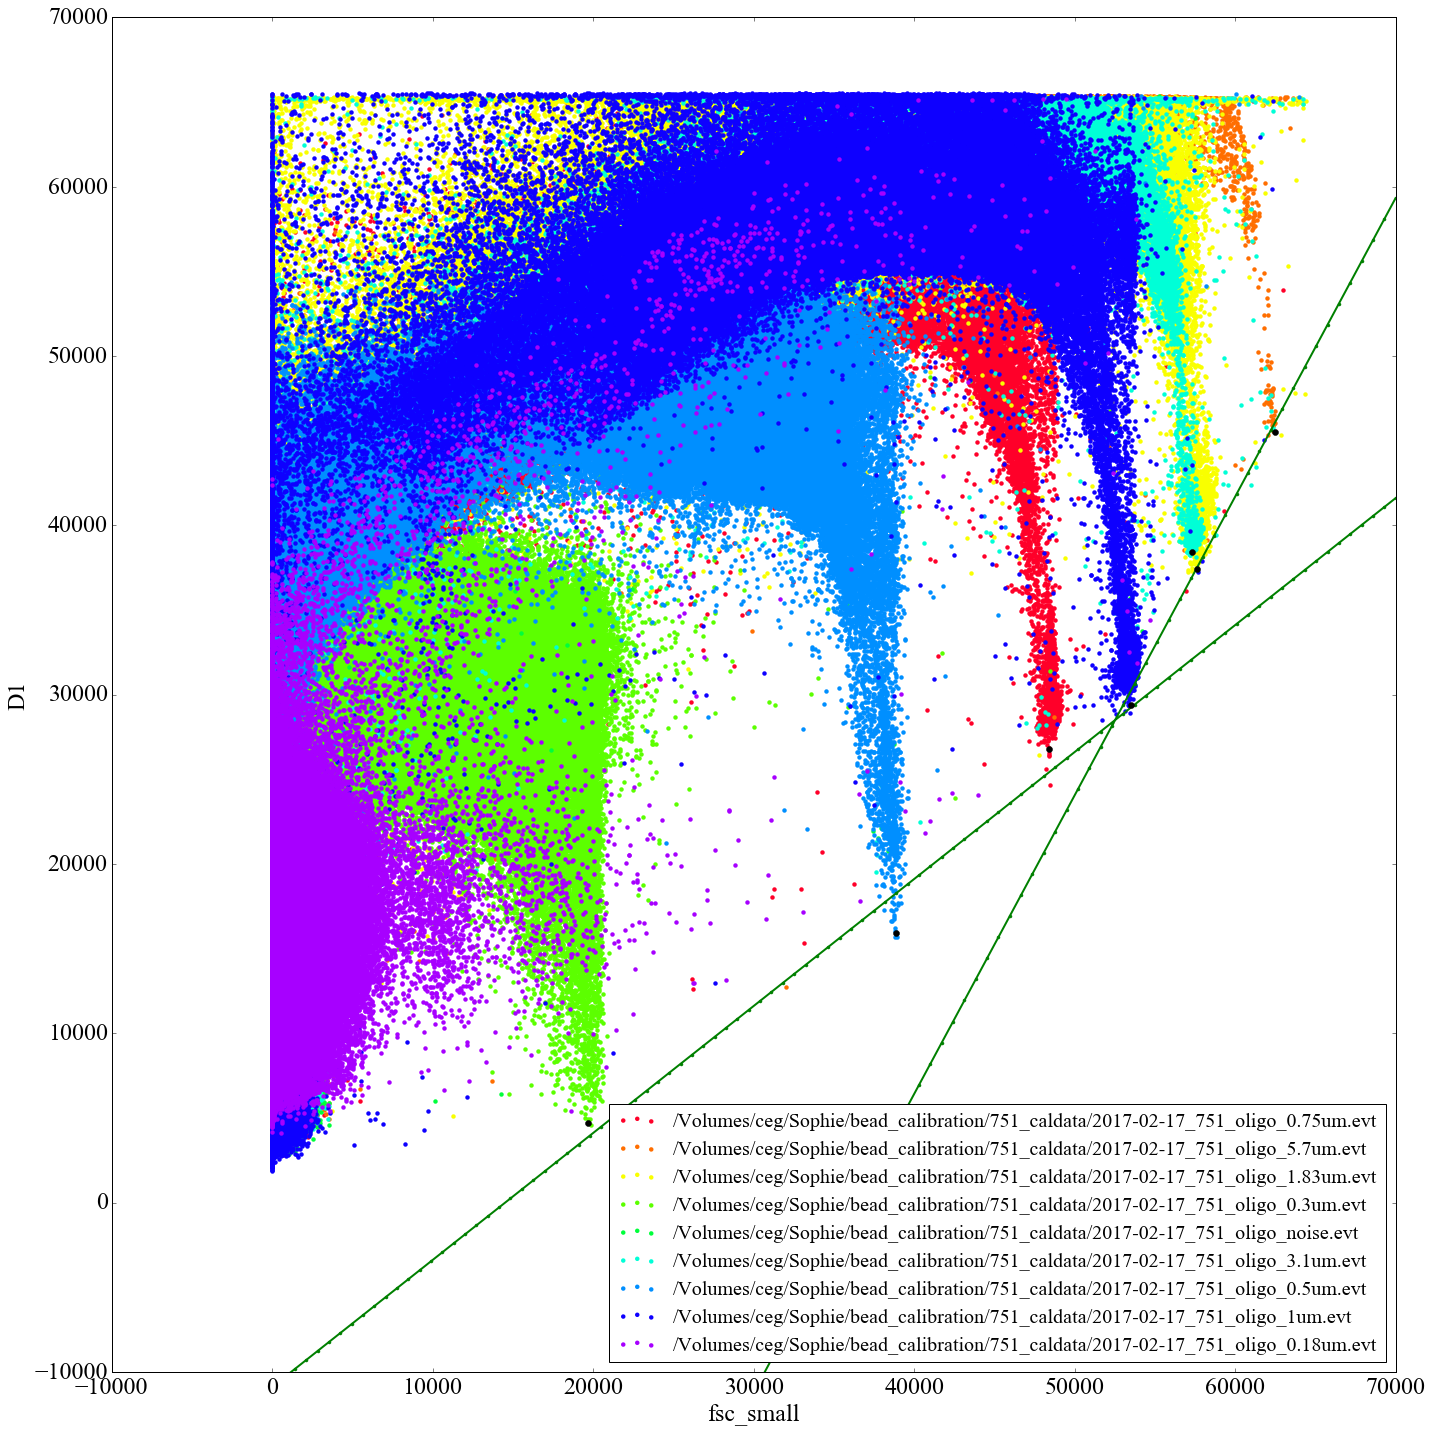

In [5]:
fig1 = plt.figure(figsize=(20,20), dpi = 600)

num_cols = len(files)

cm = plt.get_cmap('gist_rainbow')
#for i in range(num_cols):
#    color = cm(1.*i/num_cols)

cc = 0
for f in files:
    print f
    data = sfp.EVT(f, transform=False, columns=["fsc_small", "D1","D2"])
    bead_data = align_evt(data, 0.5, 0.)
    plt.scatter(bead_data['fsc_small'], bead_data['D1'], marker ='o', lw = 0, c = cm(1.*cc/num_cols), label = f)
    cc += 1


plt.xlabel('fsc_small', fontsize = 24)
plt.ylabel('D1', fontsize = 24)
plt.legend(loc = 'lower right', fontsize = 20)

plt.tick_params(axis='both', which='major', labelsize=24)

#plt.plot(xp, p(xp),'.-r', lw =2)
plt.plot(xp, ps(xp),'.-g', lw =2)
plt.plot(xp, pb(xp),'.-g', lw =2)
plt.plot(guess['fsc_small'], guess['D1'], 'ko')
plt.axis([-10000, 70000, -10000, 70000])
plt.show()

#fig1.savefig('../figures/751_oligo_beads.png', bbox_inches='tight')

In [6]:
# select instrument
inst = 751
instdir = "%3d_caldata" % inst

indir = "%s%s" % (datadir, instdir)
regime = 'coastal' # or oligo
#regime = 'oligo'

files = glob.glob('%s/*%s*.evt' % (indir, regime))

In [7]:
# best guess points for 751 coastal
#
guess2 = pd.DataFrame()
guess2['fsc_small'] = [51500, 46000, 41400, 36700, 25500, 7200]
guess2['D1'] = [44800, 36000, 28100, 23400, 12800, 4100]
guess2['bead'] = [5.7, 3.1, 1.0, 0.75, 0.5, 0.31]

# try to fit a polynomial to bead data
z = np.polyfit(guess2['fsc_small'], guess2['D1'], 2)
p = np.poly1d(z)
xp = np.linspace(0, 7e04, 100)

guess2 = guess2.sort(['bead'], ascending = 1)

small = guess2[guess2['bead']<=1].reset_index(drop = True)
small = small.append(small.ix[len(small)-1,:], ignore_index=True)

big = guess2[guess2['bead']>=1].reset_index(drop = True)
big = big.append(big.ix[len(big)-2:len(big)-1,:], ignore_index=True)
                 
weights = [1.0, 1.0, 1.0, 1.0, sys.float_info.epsilon]

# try to fit a polynomial to bead data
zs, vs = np.polyfit(small['fsc_small'], small['D1'], 1, w=weights, cov=True)
ps = np.poly1d(zs)

zb, vb = np.polyfit(big['fsc_small'], big['D1'], 1, w=weights, cov=True)
pb = np.poly1d(zb)

print "small slope: {} +/- {}".format(zs[0], np.sqrt(vs[0][0]))
print "small intercept: {} +/- {}".format(zs[1], np.sqrt(vs[1][1]))
print ' '
print "big slope: {} +/- {}".format(zb[0], np.sqrt(vb[0][0]))
print "big intercept: {} +/- {}".format(zb[1], np.sqrt(vb[1][1]))

small slope: 0.696705007351 +/- 0.128302423149
small intercept: -2198.72870362 +/- 3935.21540578
 
big slope: 1.65088121857 +/- 0.0410117100058
big intercept: -40086.9843285 +/- 1901.43684922


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_coastal_5.7um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_coastal_3.1um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_coastal_1um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_coastal_0.75um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-18_751_coastal_0.31um.evt
/Volumes/ceg/Sophie/bead_calibration/751_caldata/2017-02-17_751_coastal_0.5um.evt


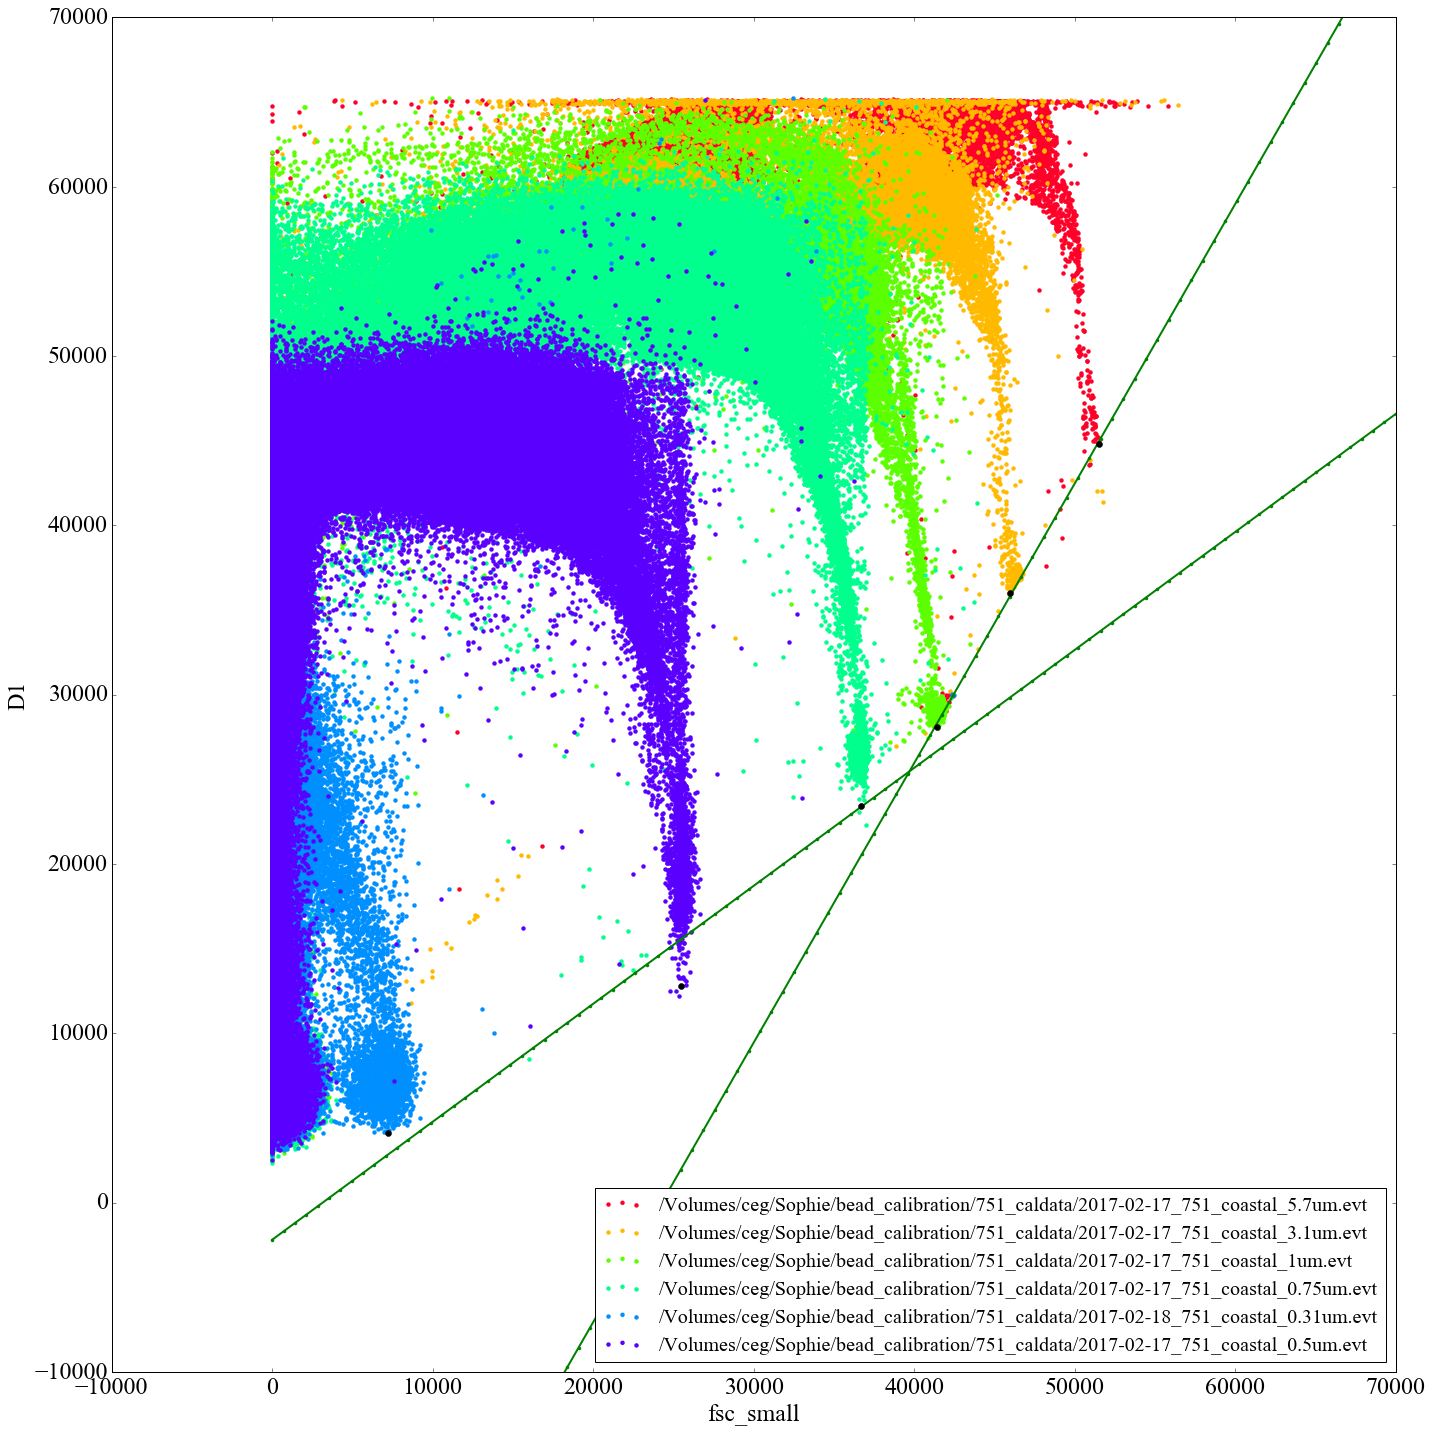

In [8]:
fig2 = plt.figure(figsize=(20,20), dpi = 600)

num_cols = len(files)

cm = plt.get_cmap('gist_rainbow')
#for i in range(num_cols):
#    color = cm(1.*i/num_cols)

cc = 0
for f in files:
    print f
    data = sfp.EVT(f, transform=False, columns=["fsc_small", "D1","D2"])
    bead_data = align_evt(data, 0.5, 0.)
    plt.scatter(bead_data['fsc_small'], bead_data['D1'], marker ='o', lw = 0, c = cm(1.*cc/num_cols), label = f)
    cc += 1


plt.xlabel('fsc_small', fontsize = 24)
plt.ylabel('D1', fontsize = 24)
plt.legend(loc = 'lower right', fontsize = 20)

plt.tick_params(axis='both', which='major', labelsize=24)

#plt.plot(xp, p(xp),'.-r', lw =2)
plt.plot(xp, ps(xp),'.-g', lw =2)
plt.plot(xp, pb(xp),'.-g', lw =2)
plt.plot(guess2['fsc_small'], guess2['D1'], 'ko')
plt.axis([-10000, 70000, -10000, 70000])
plt.show()

#fig2.savefig('../figures/751_coastal_beads.png', bbox_inches='tight')

In [9]:
# select instrument
inst = 740
instdir = "%3d_caldata" % inst

indir = "%s%s" % (datadir, instdir)
regime = 'oligo'

files = glob.glob('%s/*%s*.evt' % (indir, regime))

In [10]:
# best guess points for 740 oligo
#
guess3 = pd.DataFrame()
guess3['fsc_small'] = [61300, 60300, 56000, 49000, 43500, 30700, 8800]
guess3['D1'] = [48300, 47000, 41700, 30300, 30500, 16200, 2800]
guess3['bead'] = [5.7, 3.1, 1.83, 1.0, 0.75, 0.5, 0.3]

# try to fit a polynomial to bead data
z = np.polyfit(guess3['fsc_small'], guess3['D1'], 2)
p = np.poly1d(z)
xp = np.linspace(0, 7e04, 100)

guess3 = guess3.sort(['bead'], ascending = 1)

small = guess3[guess3['bead']<=1].reset_index(drop = True)
small = small.append(small.ix[len(small)-1,:], ignore_index=True)

big = guess3[guess3['bead']>=1].reset_index(drop = True)
big = big.append(big.ix[len(big)-1,:], ignore_index=True)
                 
weights = [1.0, 1.0, 1.0, 1.0, sys.float_info.epsilon]

# try to fit a polynomial to bead data
zs, vs = np.polyfit(small['fsc_small'], small['D1'], 1, w=weights, cov=True)
ps = np.poly1d(zs)

zb, vb = np.polyfit(big['fsc_small'], big['D1'], 1, w=weights, cov=True)
pb = np.poly1d(zb)

print "small slope: {} +/- {}".format(zs[0], np.sqrt(vs[0][0]))
print "small intercept: {} +/- {}".format(zs[1], np.sqrt(vs[1][1]))
print ' '
print "big slope: {} +/- {}".format(zb[0], np.sqrt(vb[0][0]))
print "big intercept: {} +/- {}".format(zb[1], np.sqrt(vb[1][1]))

small slope: 0.731346246265 +/- 0.123696687514
small intercept: -4184.42612675 +/- 4508.22246383
 
big slope: 1.46176376611 +/- 0.0994034780414
big intercept: -40983.9173501 +/- 5651.76305294


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-21_740_oligo_1um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-21_740_oligo_3.1um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-21_740_oligo_5.7um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-22_740_oligo_1.83um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-21_740_oligo_0.5um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-21_740_oligo_0.75um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-22_740_oligo_noise.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-21_740_oligo_0.3um.evt


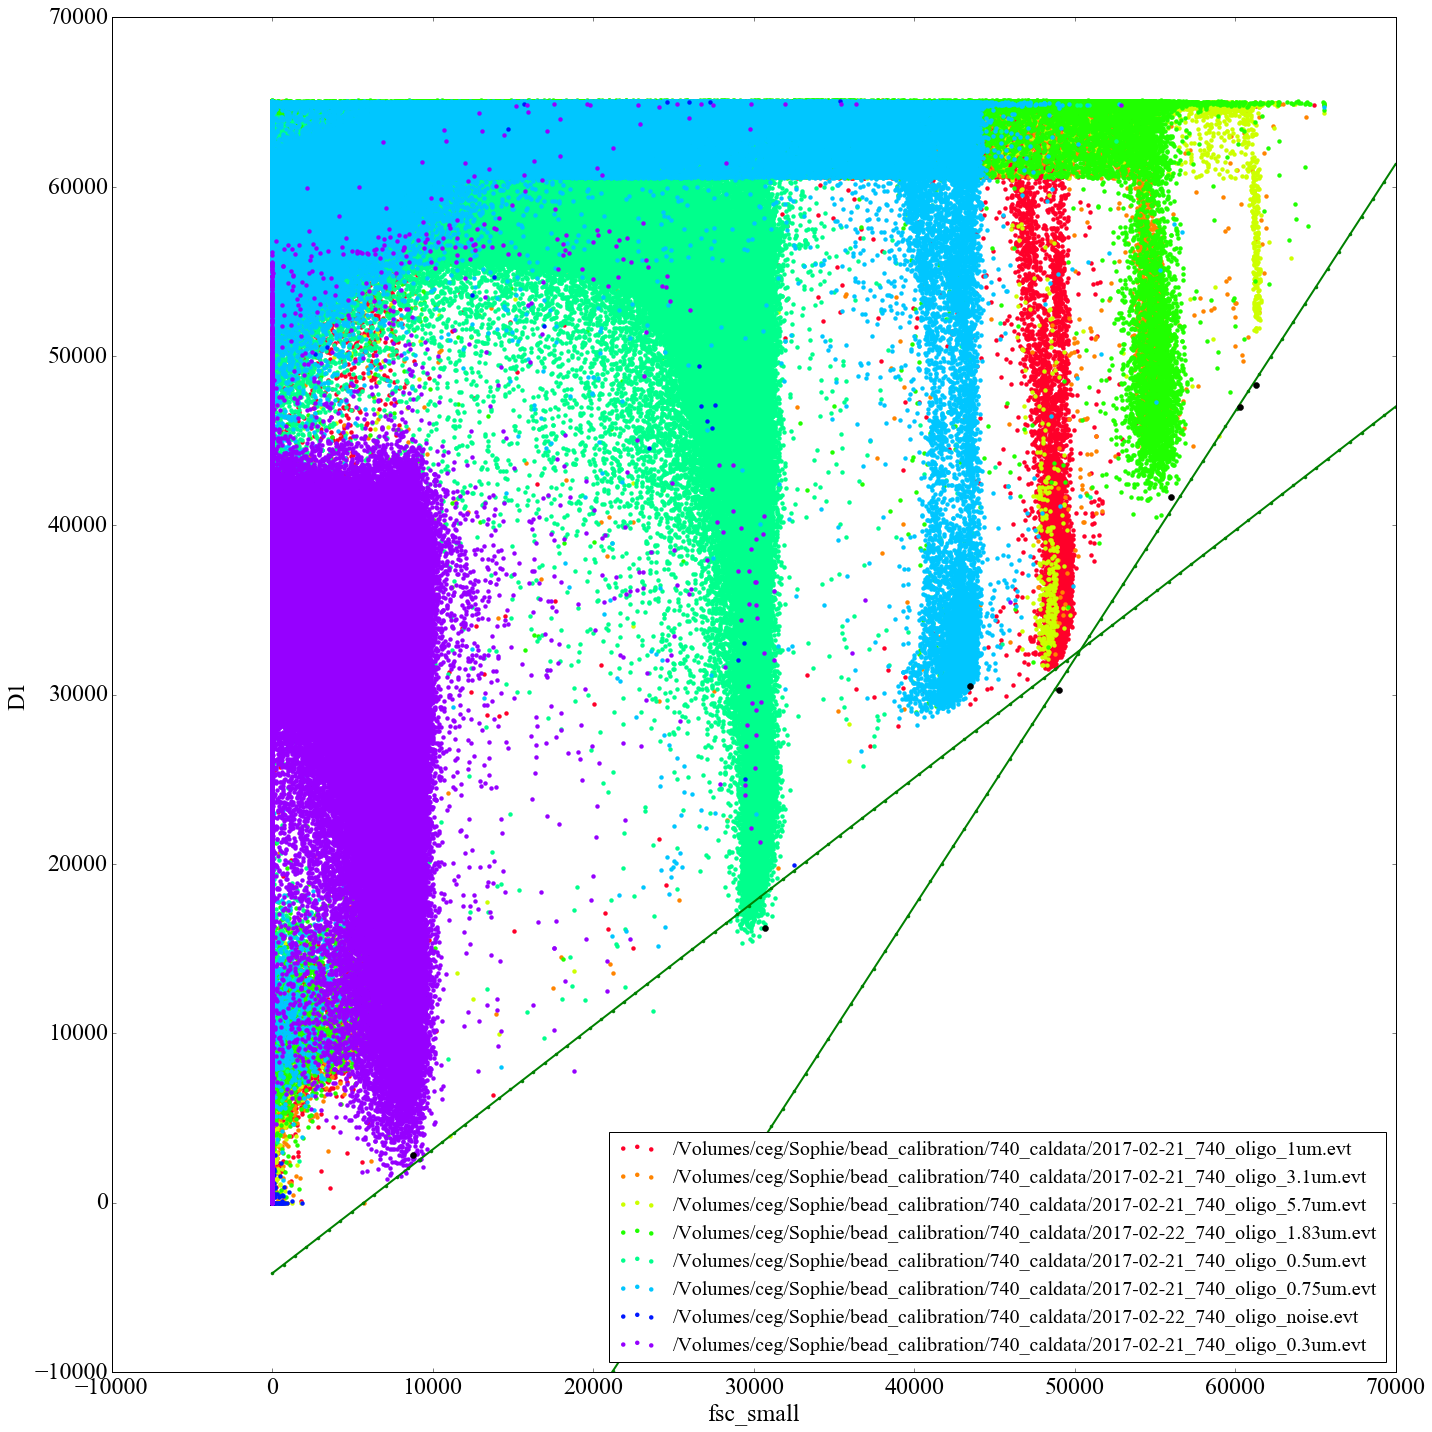

In [11]:
fig3 = plt.figure(figsize=(20,20), dpi = 600)

num_cols = len(files)

cm = plt.get_cmap('gist_rainbow')
#for i in range(num_cols):
#    color = cm(1.*i/num_cols)

cc = 0
for f in files:
    print f
    data = sfp.EVT(f, transform=False, columns=["fsc_small", "D1","D2"])
    bead_data = align_evt(data, 0.5, 0.)
    plt.scatter(bead_data['fsc_small'], bead_data['D1'], marker ='o', lw = 0, c = cm(1.*cc/num_cols), label = f)
    cc += 1

plt.xlabel('fsc_small', fontsize = 24)
plt.ylabel('D1', fontsize = 24)
plt.legend(loc = 'lower right', fontsize = 20)

plt.tick_params(axis='both', which='major', labelsize=24)

#plt.plot(xp, p(xp),'.-r', lw =2)
plt.plot(xp, ps(xp),'.-g', lw =2)
plt.plot(xp, pb(xp),'.-g', lw =2)
plt.plot(guess3['fsc_small'], guess3['D1'], 'ko')
plt.axis([-10000, 70000, -10000, 70000])
plt.show()

#fig3.savefig('../figures/740_oligo_beads.png', bbox_inches='tight')

In [12]:
# select instrument
inst = 740
instdir = "%3d_caldata" % inst

indir = "%s%s" % (datadir, instdir)
regime = 'coastal' # or oligo
#regime = 'oligo'

files = glob.glob('%s/*%s*.evt' % (indir, regime))

In [13]:
# best guess points for 740 coastal
#
guess4 = pd.DataFrame()
guess4['fsc_small'] = [51800, 46000, 46500, 38100, 33200, 19700]
guess4['D1'] = [51500, 44200, 42800, 28900, 30000, 16000]
guess4['bead'] = [5.7, 3.1, 1.83, 1.0, 0.75, 0.5]

# try to fit a polynomial to bead data
z = np.polyfit(guess4['fsc_small'], guess4['D1'], 2)
p = np.poly1d(z)
xp = np.linspace(0, 7e04, 100)

guess4 = guess4.sort(['bead'], ascending = 1)

small = guess4[guess4['bead']<=1].reset_index(drop = True)
small = small.append(small.ix[len(small)-2:len(small)-1,:], ignore_index=True)

big = guess4[guess4['bead']>=1].reset_index(drop = True)
big = big.append(big.ix[len(big)-1,:], ignore_index=True)
                 
weights = [1.0, 1.0, 1.0, 1.0, sys.float_info.epsilon]

# try to fit a polynomial to bead data
zs, vs = np.polyfit(small['fsc_small'], small['D1'], 1, w=weights, cov=True)
ps = np.poly1d(zs)

zb, vb = np.polyfit(big['fsc_small'], big['D1'], 1, w=weights, cov=True)
pb = np.poly1d(zb)

print "small slope: {} +/- {}".format(zs[0], np.sqrt(vs[0][0]))
print "small intercept: {} +/- {}".format(zs[1], np.sqrt(vs[1][1]))
print ' '
print "big slope: {} +/- {}".format(zb[0], np.sqrt(vb[0][0]))
print "big intercept: {} +/- {}".format(zb[1], np.sqrt(vb[1][1]))

small slope: 0.804947542206 +/- 0.314257127816
small intercept: 1231.37881451 +/- 9992.41309388
 
big slope: 1.65952331173 +/- 0.199326543934
big intercept: -33824.2630148 +/- 9141.40955229


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-22_740_coastal_5.7um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-22_740_coastal_1.8um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-21_740_coastal_1um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-22_740_coastal_0.75um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-22_740_coastal_0.5um.evt
/Volumes/ceg/Sophie/bead_calibration/740_caldata/2017-02-22_740_coastal_3.1um.evt


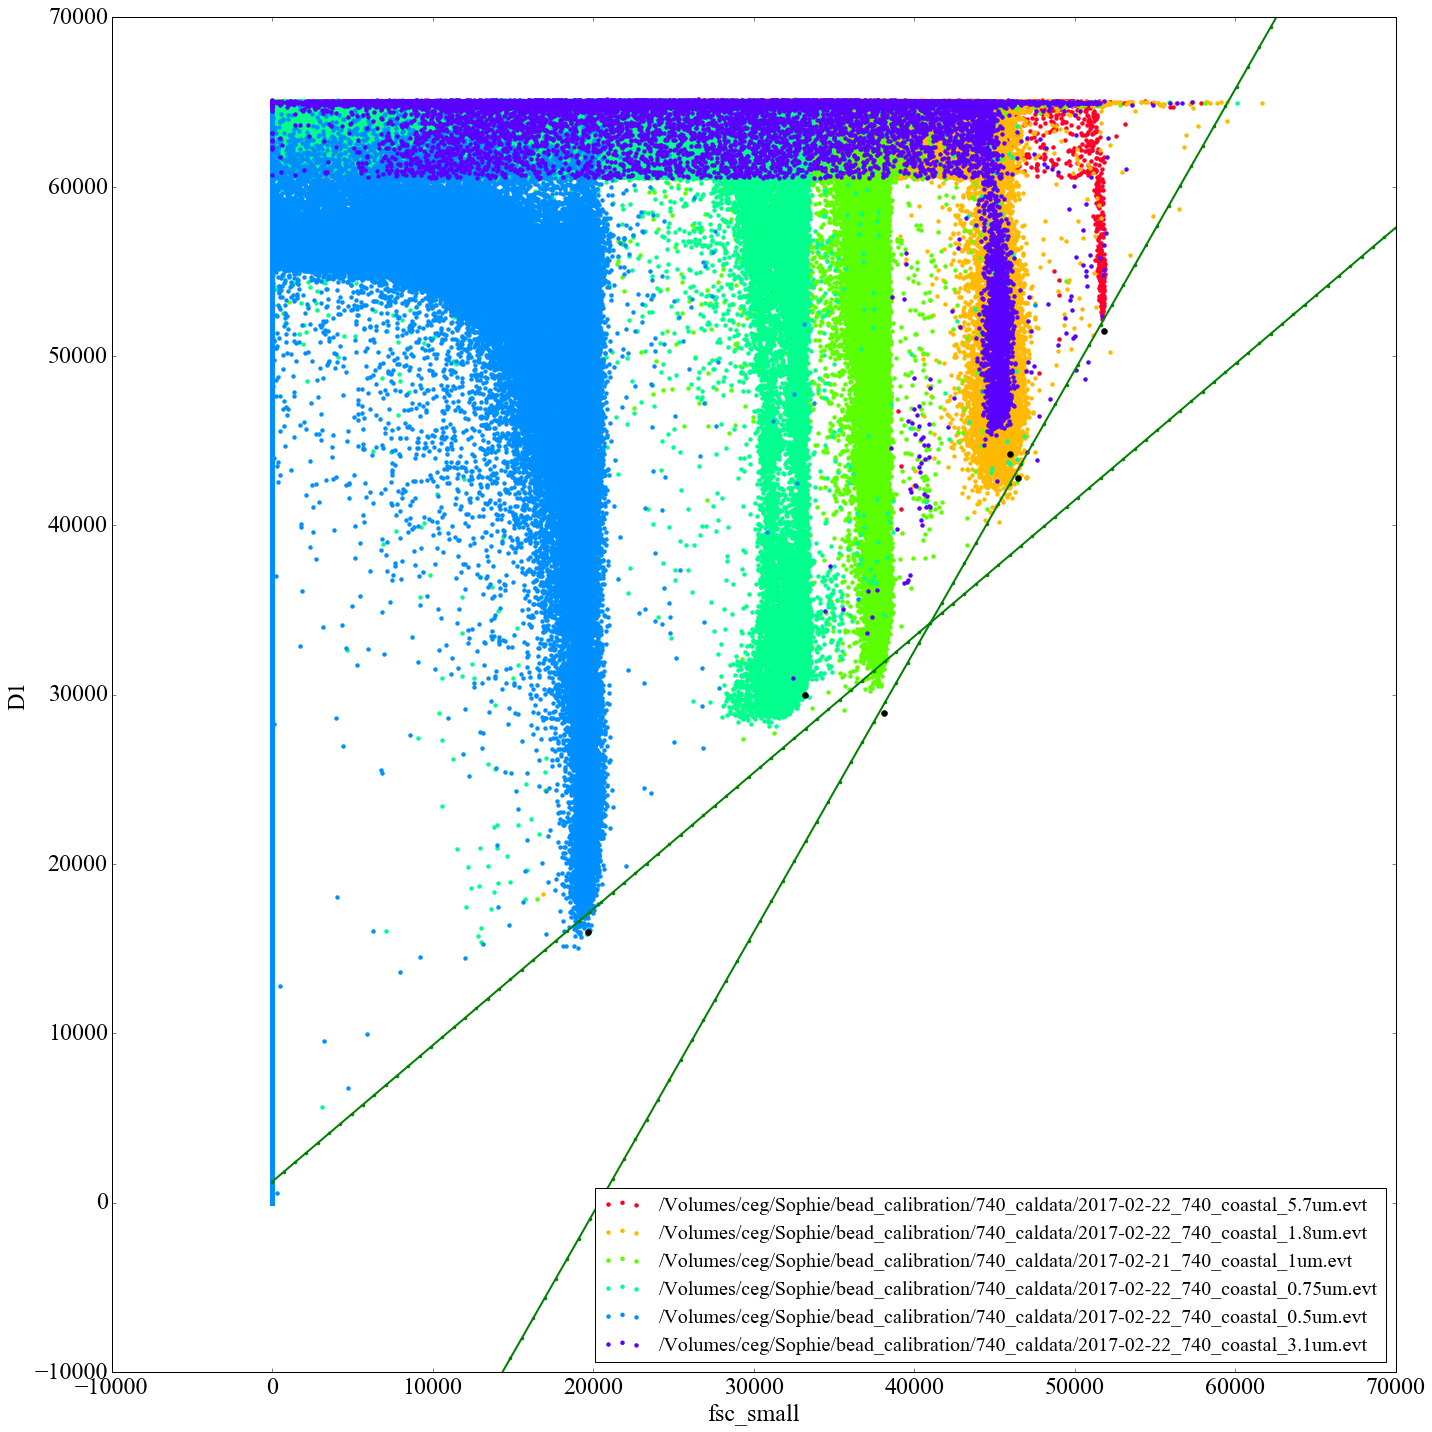

In [14]:
fig4 = plt.figure(figsize=(20,20), dpi = 600)

num_cols = len(files)

cm = plt.get_cmap('gist_rainbow')
#for i in range(num_cols):
#    color = cm(1.*i/num_cols)

cc = 0
for f in files:
    print f
    data = sfp.EVT(f, transform=False, columns=["fsc_small", "D1","D2"])
    bead_data = align_evt(data, 0.5, 0.)
    plt.scatter(bead_data['fsc_small'], bead_data['D1'], marker ='o', lw = 0, c = cm(1.*cc/num_cols), label = f)
    cc += 1

plt.xlabel('fsc_small', fontsize = 24)
plt.ylabel('D1', fontsize = 24)
plt.legend(loc = 'lower right', fontsize = 20)

plt.tick_params(axis='both', which='major', labelsize=24)

#plt.plot(xp, p(xp),'.-r', lw =2)
plt.plot(xp, ps(xp),'.-g', lw =2)
plt.plot(xp, pb(xp),'.-g', lw =2)
plt.plot(guess4['fsc_small'], guess4['D1'], 'ko')
plt.axis([-10000, 70000, -10000, 70000])
plt.show()

#fig4.savefig('../figures/740_coastal_beads.png', bbox_inches='tight')

In [15]:
# select instrument
inst = 989
instdir = "%3d_caldata" % inst

indir = "%s%s" % (datadir, instdir)
regime = 'coastal' # or oligo
#regime = 'oligo'

files = glob.glob('%s/*%s*.evt' % (indir, regime))

In [16]:
# best guess points for 989 coastal
#
guess5 = pd.DataFrame()
guess5['bead'] = [5.7, 3.1, 1.83, 1.0, 0.75, 0.5]

guess5['fsc_small'] = [51000, 45600, 45000, 40400, 35400, 23500] 
guess5['D1'] = [36100, 32000, 28700, 22600, 19300,  8650]
        
# try to fit a polynomial to bead data
z = np.polyfit(guess5['fsc_small'], guess5['D1'], 2)
p = np.poly1d(z)
xp = np.linspace(0, 7e04, 100)

guess5 = guess5.sort(['bead'], ascending = 1)

small = guess5[guess5['bead']<=1].reset_index(drop = True)
small = small.append(small.ix[len(small)-2:len(small)-1,:], ignore_index=True)

big = guess5[guess5['bead']>=1]
big = big.append(big.ix[len(big)-1,:], ignore_index=True)
                 
weights = [1.0, 1.0, 1.0, sys.float_info.epsilon, sys.float_info.epsilon]

# try to fit a polynomial to bead data
zs, vs = np.polyfit(small['fsc_small'], small['D1'], 1, w=weights, cov=True)
ps = np.poly1d(zs)

weights = [1.0, 1.0, 1.0, 1.0, sys.float_info.epsilon]

zb, vb = np.polyfit(big['fsc_small'], big['D1'], 1, w=weights, cov=True)
pb = np.poly1d(zb)

print "small slope: {} +/- {}".format(zs[0], np.sqrt(vs[0][0]))
print "small intercept: {} +/- {}".format(zs[1], np.sqrt(vs[1][1]))
print ' '
print "big slope: {} +/- {}".format(zb[0], np.sqrt(vb[0][0]))
print "big intercept: {} +/- {}".format(zb[1], np.sqrt(vb[1][1]))

small slope: 0.83806554332 +/- 0.0535448902963
small intercept: -10889.9694839 +/- 1812.52155923
 
big slope: 1.27636234961 +/- 0.311754279359
big intercept: -28224.4869073 +/- 14233.144953


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_coastal_3.1um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-03-01_989_coastal_1.83um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-03-01_989_coastal_0.5um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_coastal_1.0um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-03-01_989_coastal_noise.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_coastal_5.7um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-03-01_989_coastal_0.3um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-03-01_989_coastal_0.75um.evt


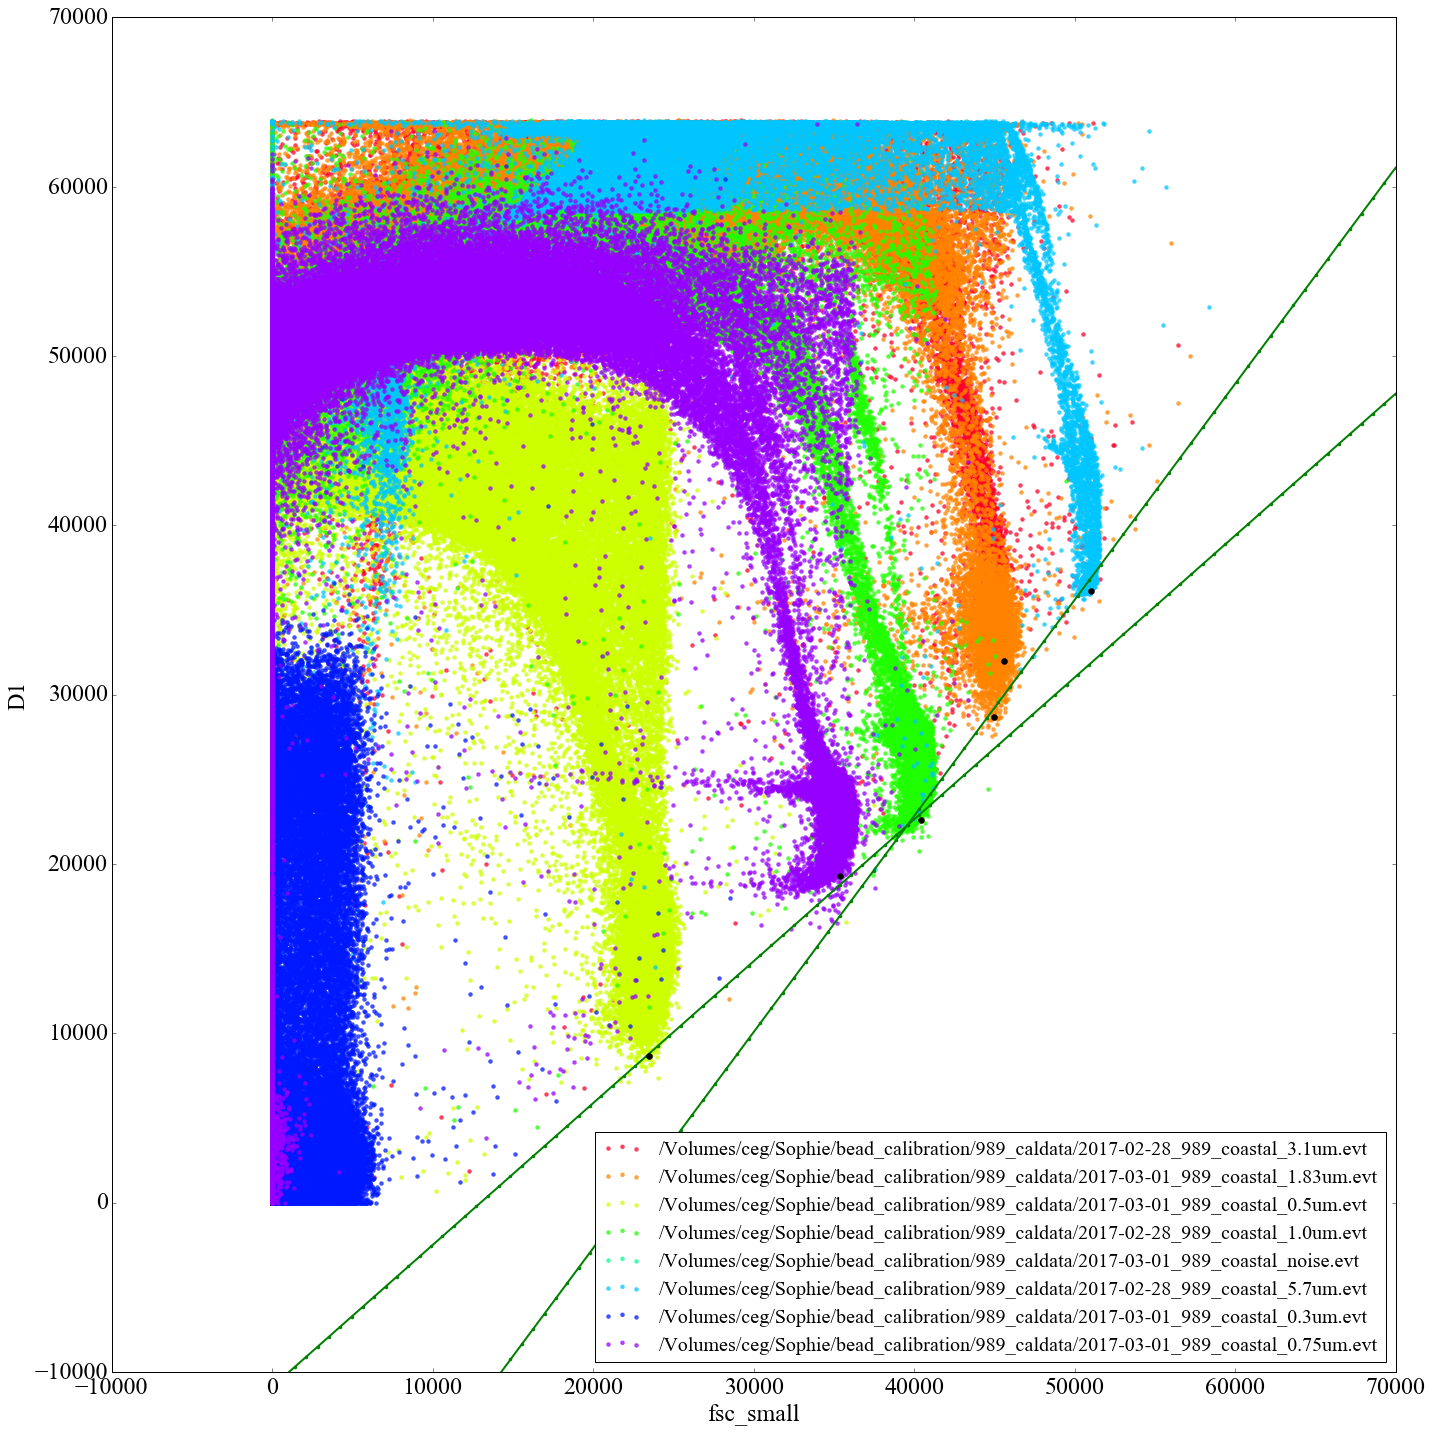

In [17]:
fig5 = plt.figure(figsize=(20,20), dpi = 600)

num_cols = len(files)

cm = plt.get_cmap('gist_rainbow')
#for i in range(num_cols):
#    color = cm(1.*i/num_cols)

cc = 0
for f in files:
    print f
    data = sfp.EVT(f, transform=False, columns=["fsc_small", "D1","D2"])
    bead_data = align_evt(data, 0.5, 0.)
    plt.scatter(bead_data['fsc_small'], bead_data['D1'], marker ='o', lw = 0, c = cm(1.*cc/num_cols), label = f, alpha = 0.75)
    cc += 1

plt.xlabel('fsc_small', fontsize = 24)
plt.ylabel('D1', fontsize = 24)
plt.legend(loc = 'lower right', fontsize = 20)

plt.tick_params(axis='both', which='major', labelsize=24)

#plt.plot(xp, p(xp),'.-r', lw =2)
plt.plot(xp, ps(xp),'.-g', lw =2)
plt.plot(xp, pb(xp),'.-g', lw =2)
plt.plot(guess5['fsc_small'], guess5['D1'], 'ko')
plt.axis([-10000, 70000, -10000, 70000])
plt.show()

#fig5.savefig('../figures/989_coastal_beads.png', bbox_inches='tight')

In [18]:
# select instrument
inst = 989
instdir = "%3d_caldata" % inst

indir = "%s%s" % (datadir, instdir)
regime = 'oligo'

files = glob.glob('%s/*%s*.evt' % (indir, regime))

In [19]:
# best guess points for 989 oligo
#
guess6 = pd.DataFrame()
guess6['fsc_small'] = [60300, 54600, 54700, 49800, 45600, 34400, 16200]
guess6['D1'] = [37900, 33500, 31800, 24100, 19600, 11300, 600]
guess6['bead'] = [5.7, 3.1, 1.83, 1.0, 0.75, 0.5, 0.3]

# try to fit a polynomial to bead data
z = np.polyfit(guess6['fsc_small'], guess6['D1'], 2)
p = np.poly1d(z)
xp = np.linspace(0, 7e04, 100)

guess6 = guess6.sort(['bead'], ascending = 1)

small = guess6[guess6['bead']<=1].reset_index(drop = True)
small = small.append(small.ix[len(small)-1,:], ignore_index=True)

big = guess6[guess6['bead']>=1]
big = big.append(big.ix[len(big)-1,:], ignore_index=True)
                 
weights = [1.0, 1.0, 1.0, 1.0, sys.float_info.epsilon]

# try to fit a polynomial to bead data
zs, vs = np.polyfit(small['fsc_small'], small['D1'], 1, w=weights, cov=True)
ps = np.poly1d(zs)

zb, vb = np.polyfit(big['fsc_small'], big['D1'], 1, w=weights, cov=True)
pb = np.poly1d(zb)

print "small slope: {} +/- {}".format(zs[0], np.sqrt(vs[0][0]))
print "small intercept: {} +/- {}".format(zs[1], np.sqrt(vs[1][1]))
print ' '
print "big slope: {} +/- {}".format(zb[0], np.sqrt(vb[0][0]))
print "big intercept: {} +/- {}".format(zb[1], np.sqrt(vb[1][1]))

small slope: 0.684679089027 +/- 0.0686550060271
small intercept: -11090.7867495 +/- 2660.14893224
 
big slope: 1.29688913004 +/- 0.340067576253
big intercept: -39309.3687828 +/- 18695.5068974


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_0.3um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_0.75um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-03-01_989_oligo_noise.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_1.83um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_5.7um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_3.1um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_1.0um.evt
/Volumes/ceg/Sophie/bead_calibration/989_caldata/2017-02-28_989_oligo_0.5um.evt


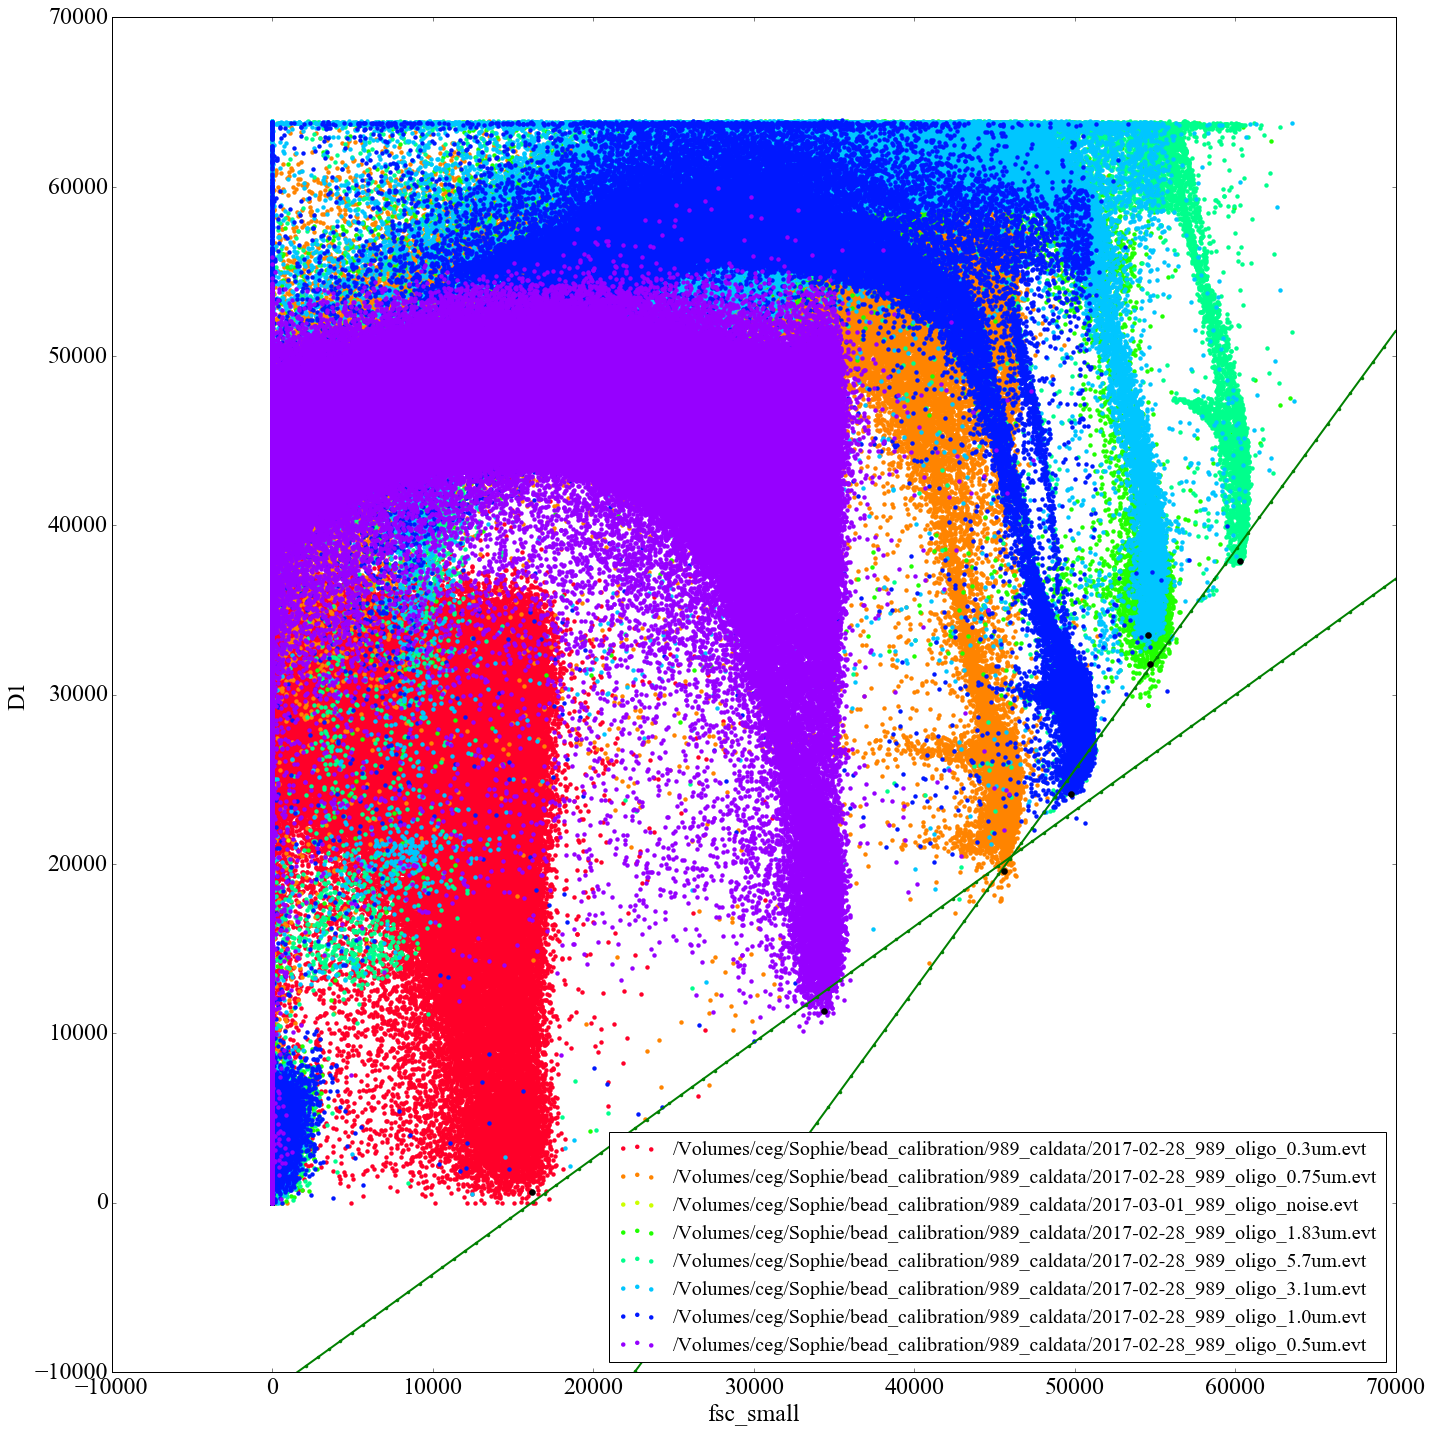

In [20]:
fig6 = plt.figure(figsize=(20,20), dpi = 600)

num_cols = len(files)

cm = plt.get_cmap('gist_rainbow')
#for i in range(num_cols):
#    color = cm(1.*i/num_cols)

cc = 0
for f in files:
    print f
    data = sfp.EVT(f, transform=False, columns=["fsc_small", "D1","D2"])
    bead_data = align_evt(data, 0.5, 0.)
    plt.scatter(bead_data['fsc_small'], bead_data['D1'], marker ='o', lw = 0, c = cm(1.*cc/num_cols), label = f)
    cc += 1

plt.xlabel('fsc_small', fontsize = 24)
plt.ylabel('D1', fontsize = 24)
plt.legend(loc = 'lower right', fontsize = 20)

plt.tick_params(axis='both', which='major', labelsize=24)

#plt.plot(xp, p(xp),'.-r', lw =2)
plt.plot(xp, ps(xp),'.-g', lw =2)
plt.plot(xp, pb(xp),'.-g', lw =2)
plt.plot(guess6['fsc_small'], guess6['D1'], 'ko')
plt.axis([-10000, 70000, -10000, 70000])
plt.show()

#fig6.savefig('../figures/989_oligo_beads.png', bbox_inches='tight')